In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lantian773030/pokemonclassification -p ./data/
!unzip ./data/pokemonclassification.zip -d ./data/pokemon/


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ./data/pokemon/PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: ./data/pokemon/PokemonData/Golbat/a45a14a67a7348b

In [ ]:
import os
import shutil

data_path = './data/pokemon'
if os.path.exists(os.path.join(data_path, 'PokemonData')):
    pokemon_data_dir = os.path.join(data_path, 'PokemonData')
    for item in os.listdir(pokemon_data_dir):
        shutil.move(os.path.join(pokemon_data_dir, item), data_path)
    os.rmdir(pokemon_data_dir)

dossiers = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print(f"Dossiers trouvés: {len(dossiers)}")
print(f"Premiers dossiers: {sorted(dossiers)[:10]}")


Dossiers trouvés: 150
Premiers dossiers: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('./data/pokemon', transform=transform)
print(f"Images totales: {len(dataset)}")
print(f"Classes: {len(dataset.classes)}")

labels = np.array(dataset.targets)
indices = np.arange(len(labels))

train_idx, temp_idx, _, _ = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, labels[temp_idx], test_size=0.5, stratify=labels[temp_idx], random_state=42
)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Taille train: {len(train_ds)}")
print(f"Taille val: {len(val_ds)}")
print(f"Taille test: {len(test_ds)}")


Images totales: 6820
Classes: 150
Taille train: 4774
Taille val: 1023
Taille test: 1023


In [ ]:
def loader_to_numpy(loader):
    X, y = [], []
    for images, labels in loader:
        X.append(images.view(images.size(0), -1).numpy())
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

X_train, y_train = loader_to_numpy(train_loader)
X_val, y_val = loader_to_numpy(val_loader)
X_test, y_test = loader_to_numpy(test_loader)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (4774, 4096)
X_val shape: (1023, 4096)
X_test shape: (1023, 4096)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Variance expliquée: {pca.explained_variance_ratio_.sum():.3f}")
print(f"X_train_pca shape: {X_train_pca.shape}")


Variance expliquée: 0.916
X_train_pca shape: (4774, 150)


In [ ]:
print(f"Classes train: {len(np.unique(y_train))}")
print(f"Classes val: {len(np.unique(y_val))}")
print(f"Classes test: {len(np.unique(y_test))}")
print(f"Labels train (top 10): {np.bincount(y_train)[:10]}")


Classes train: 150
Classes val: 150
Classes test: 150
Labels train (top 10): [24 24 18 29 29 29 31 24 28 29]


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 10, 20],
    'gamma': ['scale', 0.01, 0.1]
}

svm = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Accuracy train: {grid_search.score(X_train_pca, y_train):.3f}")
print(f"Accuracy val: {grid_search.score(X_val_pca, y_val):.3f}")


Meilleurs paramètres: {'C': 10, 'gamma': 'scale'}
Accuracy train: 0.994
Accuracy val: 0.211


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid_search.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy test: {grid_search.score(X_test_pca, y_test):.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.20      0.17      0.18         6
           2       0.00      0.00      0.00         4
           3       0.12      0.17      0.14         6
           4       0.14      0.17      0.15         6
           5       0.57      0.67      0.62         6
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         5
           8       0.14      0.17      0.15         6
           9       0.00      0.00      0.00         7
          10       0.29      0.67      0.40         6
          11       1.00      0.75      0.86         4
          12       0.00      0.00      0.00         5
          13       0.15      0.33      0.21         6
          14       0.14      0.20      0.17         5
          15       0.12      0.29      0.17         7
          16       0.33      0.14      0.20         7
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy test: 0.202


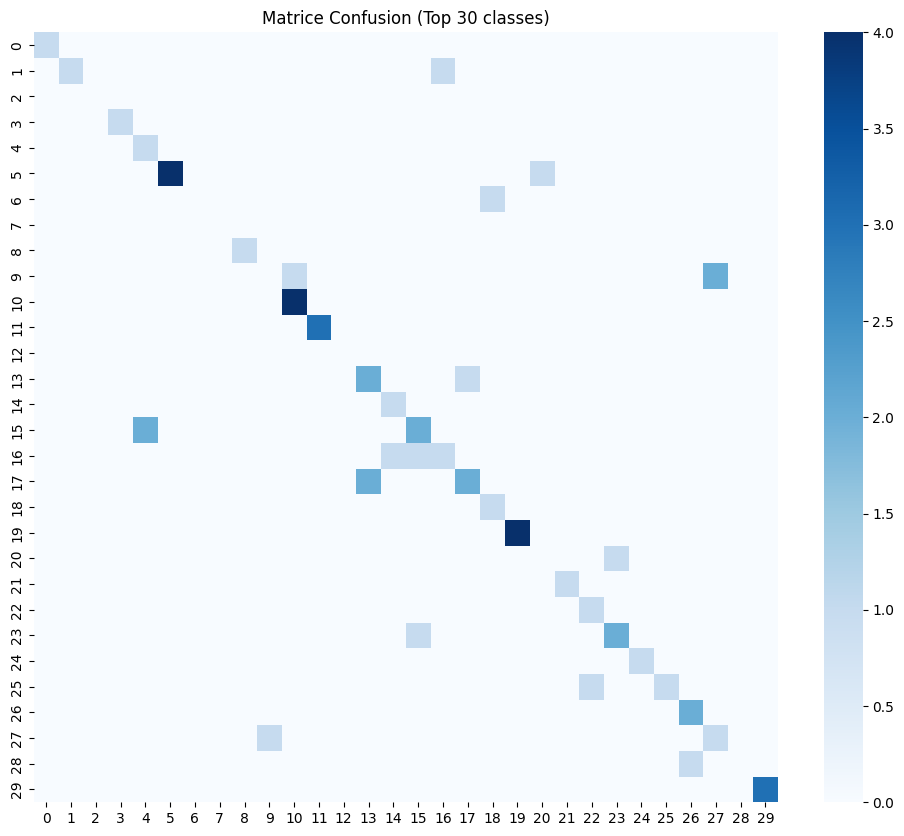

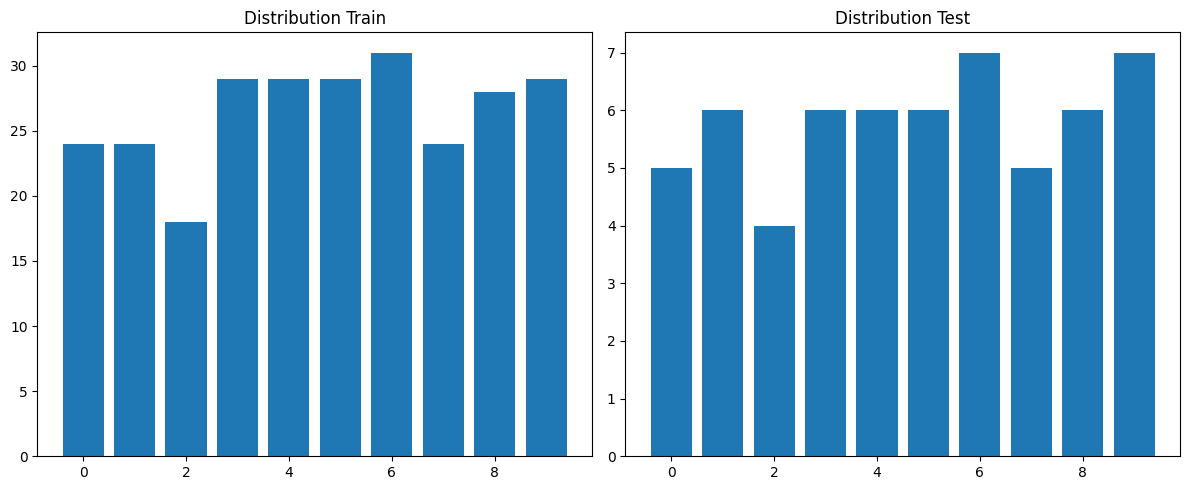

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Matrice confusion top 30
plt.figure(figsize=(12, 10))
cm_top = confusion_matrix(y_test, y_pred)[:30, :30]
sns.heatmap(cm_top, cmap='Blues')
plt.title('Matrice Confusion (Top 30 classes)')
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution classes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(10), np.bincount(y_train)[:10])
axes[0].set_title('Distribution Train')
axes[1].bar(range(10), np.bincount(y_test)[:10])
axes[1].set_title('Distribution Test')
plt.tight_layout()
plt.savefig('figures/distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import joblib

joblib.dump(grid_search.best_estimator_, 'models/svm_pokemon.joblib')
joblib.dump(pca, 'models/pca_pokemon.joblib')
joblib.dump(dataset.classes, 'models/classes_pokemon.pkl')

results = {
    'accuracy_train': grid_search.score(X_train_pca, y_train),
    'accuracy_val': grid_search.score(X_val_pca, y_val),
    'accuracy_test': grid_search.score(X_test_pca, y_test),
    'best_params': grid_search.best_params_,
    'pca_variance': pca.explained_variance_ratio_.sum()
}
joblib.dump(results, 'models/results.pkl')

print("Modèles et résultats sauvegardés")


Modèles et résultats sauvegardés


In [ ]:
requirements = [
    'torch',
    'torchvision',
    'scikit-learn',
    'seaborn',
    'matplotlib',
    'numpy',
    'joblib',
    'kaggle'
]

with open('requirements.txt', 'w') as f:
    f.write('\n'.join(requirements))

print("requirements.txt créé")


requirements.txt créé


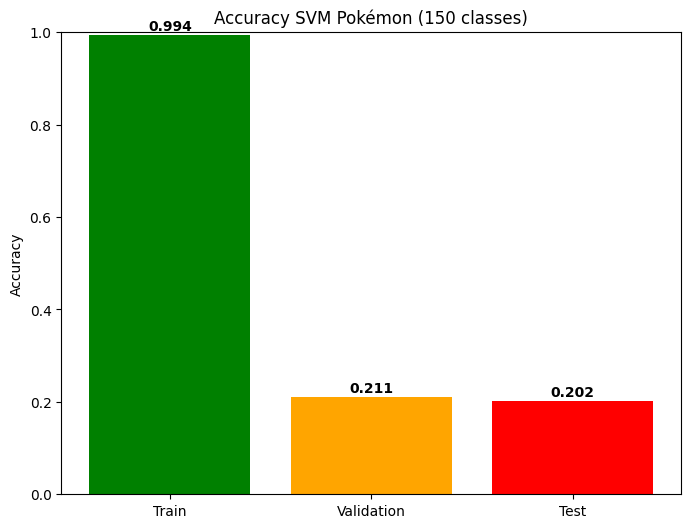

 figures/accuracy_bar.png


In [ ]:
metrics = {
    'Train': 0.994,
    'Validation': 0.211,
    'Test': 0.202
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['green', 'orange', 'red'])
plt.title('Accuracy SVM Pokémon (150 classes)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.savefig('figures/accuracy_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/accuracy_bar.png")


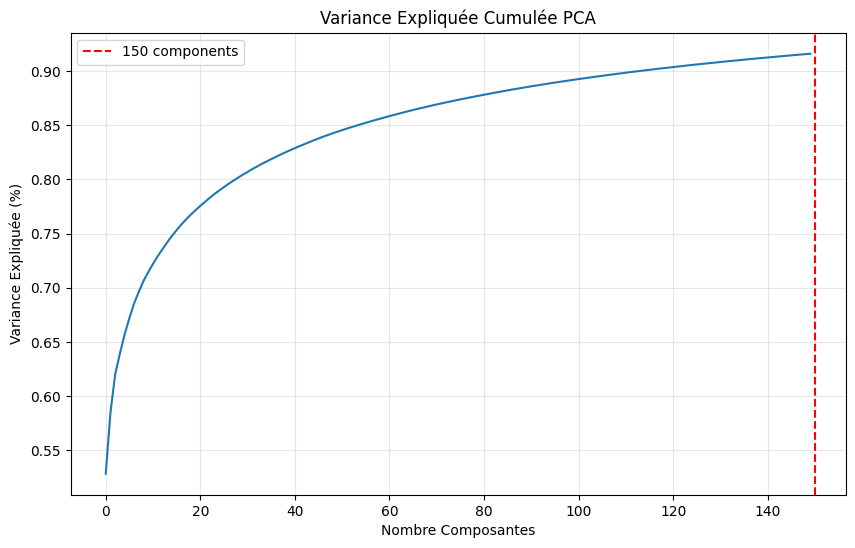

 figures/pca_variance.png


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=150, color='red', linestyle='--', label='150 components')
plt.title('Variance Expliquée Cumulée PCA')
plt.xlabel('Nombre Composantes')
plt.ylabel('Variance Expliquée (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/pca_variance.png")


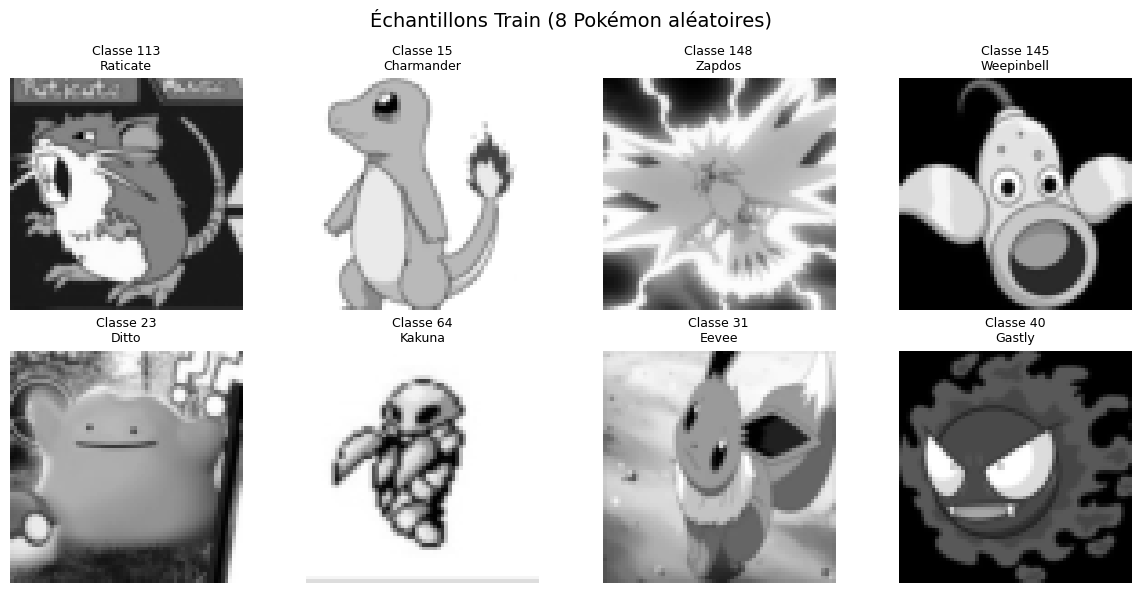

 figures/train_samples.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# images aléatoires du train (64x64 grayscale)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
train_indices = np.random.choice(len(train_ds), 8, replace=False)

for i, idx in enumerate(train_indices):
    img, label = train_ds[idx]
    ax = axes[i//4, i%4]
    ax.imshow(img.squeeze(), cmap='gray')  # squeeze(1,64,64) -> 64x64
    ax.set_title(f'Classe {label}\n{dataset.classes[label]}', fontsize=9)
    ax.axis('off')

plt.suptitle('Échantillons Train (8 Pokémon aléatoires)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/train_samples.png', dpi=300, bbox_inches='tight')
plt.show()
print(" figures/train_samples.png")


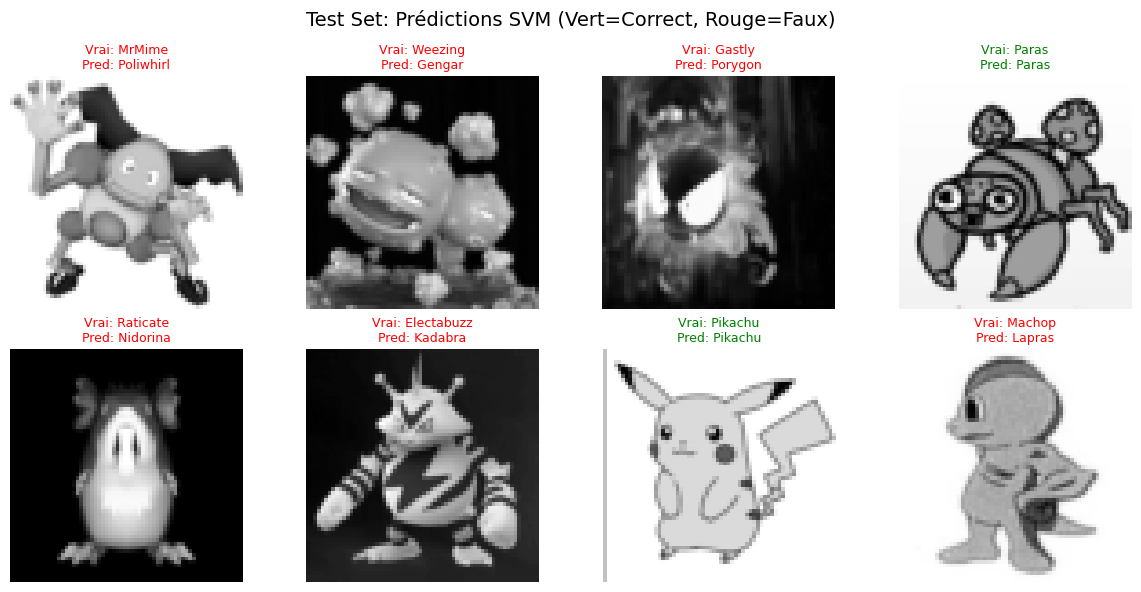

figures/test_predictions.png


In [ ]:
# images test avec VRAIES vs PRÉDICTIONS SVM
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
test_indices = np.random.choice(len(test_ds), 8, replace=False)

for i, idx in enumerate(test_indices):
    img, true_label = test_ds[idx]
    img_pca = pca.transform(img.view(1, -1))  # Flatten + PCA
    pred_label = grid_search.predict(img_pca)[0]

    ax = axes[i//4, i%4]
    ax.imshow(img.squeeze(), cmap='gray')

    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Vrai: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}',
                color=color, fontsize=9)
    ax.axis('off')

plt.suptitle('Test Set: Prédictions SVM (Vert=Correct, Rouge=Faux)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("figures/test_predictions.png")


In [ ]:
git init

SyntaxError: invalid syntax (ipython-input-2830201818.py, line 1)